<h1 style="text-align: center">
Deep Learning HW4 </br>
Vector Quantized Variational Autoencoder
</h1>



<style>
    table {
      width: 100%;
      border-collapse: collapse;
    }

    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }

    th {
      background-color: #f2f2f2;
    }

    .box {
      border: 1px solid #000;
      padding: 10px;
      width: 400px; /* Adjust the width as needed */
      margin: 20px auto;
    }
  </style>
</head>
<body>

<div class="box">
  <table>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Git:</td>
      <td><a href="https://github.com/AliNikkhah2001/DataScience02" target="_blank">https://github.com/AliNikkhah2001/DeepLearning02</a></td>
    </tr>
  </table>
</div>



## Comparison tbetween  VQ-VAE and VAE:

**1. Discrete Latent Space:**
   - **VAE:**
     \\[ z \sim \mathcal{N}(\mu, \sigma^2) \\]
   - **VQ-VAE:**
\begin{align}
&\textbf{input }x \tag{W x H x C}\\
z_e &= f(x) \tag{w x h x d}\\
z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
\end{align}


**2. Improved Sample Quality:**
   - **VAE:**
     \\[ p(x|z) = \mathcal{N}(\mu_{\theta}(z), \sigma_{\theta}(z)^2) \\]
   - **VQ-VAE:**
     \\[ p(x|z) = \text{softmax}(\beta(e(z) - \text{sg}[j])) \quad \text{where } \beta \text{ is a temperature parameter} \\]
   VQ-VAE incorporates a softmax function to improve the quality of generated samples by considering discrete representations during the decoding process.

**3. Stable Training:**
   - **VAE:**
     \\[ \mathcal{L} = -\mathbb{E}_{q(z|x)}[\log p(x|z)] + \text{KL}(q(z|x) || p(z)) \\]
   - **VQ-VAE:**

     

\\[\mathcal L_{\text{VQ-VAE}}(x) = - \mathbb{E}_{z \sim f(x)}{p(x | z)} + \| z_e - \bar{z_q}\|^2 + \|\bar{z_e} - z_q\|^2 \\]


## Import and Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import IPython
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from torchvision import transforms,datasets,models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Current device: {device}")

Current device: cuda


In [3]:

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST('data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data', train=False, download=True, transform=transform)





100%|██████████| 9912422/9912422 [00:00<00:00, 151208597.90it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25147538.68it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48892142.89it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7003870.87it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



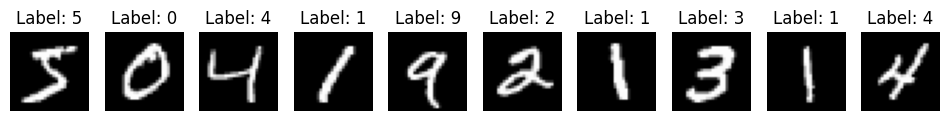

In [4]:
# Plot some images from the dataset
def plot_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i, (image, label) in enumerate(dataset):
        if i >= num_images:
            break
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

plot_images(train_set)

In [7]:

training_loader = DataLoader(train_set,batch_size=64, shuffle=True,pin_memory=True)
validation_loader = DataLoader(test_set,batch_size=16,shuffle=True,pin_memory=True)



In [8]:
# Print dimensionalities
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 60000
Test set size: 10000


In [9]:
# Display shapes of inputs (images and labels)
for batch_idx, (images, labels) in enumerate(training_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break  # Print the shape of the first batch onl

Batch 1:
Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


<h2>Implemenation of encoder, decoder and quantizer</h2>

<h5>Resnet Block Implementation</h5>

In [11]:

# Define the Residual block and ResidualBlocks class
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super(Residual, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        residual = x
        x = self.block(x)
        x = x + residual  # Add the input tensor to the output of the block
        return x

class ResidualBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, residual_layers, hidden_channels):
        super(ResidualBlocks, self).__init__()
        self.residual_layers = residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, out_channels, hidden_channels)
                for _ in range(self.residual_layers)
            ]
        )

    def forward(self, x):
        for i in range(self.residual_layers):
            x = x + self.layers[i](x)
            x = F.relu(x)
        return x


In [12]:
# Function to check output of Residual block
def check_residual_output():
    # Define input tensor
    input_tensor = torch.randn(1, 64, 28, 28)  # Example input tensor with specified dimensions

    # Initialize Residual block with specified parameters
    residual_block = Residual(in_channels=64, out_channels=64, hidden_channels=32)

    # Pass input through the Residual block
    output = residual_block(input_tensor)

    # Print output shape
    print(f"Output shape: {output.shape}")
    return output

# Call the function to check the output of the Residual block
residual_output = check_residual_output()

Output shape: torch.Size([1, 64, 28, 28])


In [13]:
import torch
import torch.nn as nn

# Define the Encoder class (assuming Residual class is imported or defined elsewhere)
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels=128, hidden_layers=32, residual_layers=2):
        super(Encoder, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 4, 2, 1),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU()
        )
        self.residual_block = ResidualBlocks(out_channels, out_channels, residual_layers, hidden_layers)

    def forward(self, x):
        x = self.layer_1(x)
        #print(f"Layer 1 output shape: {x.shape}")

        x = self.layer_2(x)
        #print(f"Layer 2 output shape: {x.shape}")

        x = self.layer_3(x)
        #print(f"Layer 3 output shape: {x.shape}")

        x = self.residual_block(x)
        #print(f"Residual block output shape: {x.shape}")

        return x



In [14]:
# Function to check the dimensions of the Encoder output
def check_encoder_dimensions():
    # Assuming 3 channels for the input tensor (adjust as needed)
    in_channels = 3
    sample_input = torch.randn(1, in_channels, 64, 64)  # Creating a sample input tensor

    # Initialize the Encoder
    encoder = Encoder(in_channels=in_channels)

    # Pass the sample input through the Encoder
    output = encoder(sample_input)

    # Return the final output shape
    return output.shape

# Call the function to check the dimensions of the Encoder output
encoder_output_shape = check_encoder_dimensions()
print(f"Final Encoder output shape: {encoder_output_shape}")


Final Encoder output shape: torch.Size([1, 128, 16, 16])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the VectorQuantization class
class VectorQuantization(nn.Module):
    def __init__(self, number_embeddings, embedding_dimension):
        super(VectorQuantization, self).__init__()

        self.num_embeddings = number_embeddings
        self.embedding_dim = embedding_dimension

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)

        # Assuming 'device' is defined elsewhere in the code
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, x):
        # Convert (Batch, channel, Height, Width) to (Batch, Height, Width, Channel) for flattening
        x = x.permute(0, 2, 3, 1)

        # Flatten input
        latent = x.reshape(-1, self.embedding_dim)

        # Calculate the L2 Norm between latent and Embedded weights
        distances = (torch.sum(latent**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(latent, self.embedding.weight.t()))

        # Encoding starts from here
        encoded_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # One Hot Encoding starts from here
        encoded_vector = F.one_hot(encoded_indices, self.num_embeddings).type(x.dtype)
        encoded_vector = encoded_vector.view(encoded_vector.shape[0], encoded_vector.shape[2])

        # Quantization of the Encodings
        quantized_vector = torch.matmul(encoded_vector, self.embedding.weight)

        # Bringing back to the original shape
        quantized_vector = quantized_vector.view(x.shape)

        # Loss calculation
        beta = 0.25  # Hyperparameter
        commitment_loss = F.mse_loss(quantized_vector.detach(), x)
        codebook_loss = F.mse_loss(quantized_vector, x.detach())
        vq_loss = codebook_loss + beta * commitment_loss

        # Detach and update quantized vector for backpropagation
        quantized_vector = x + (quantized_vector - x).detach()
        quantized_vector = quantized_vector.permute(0, 3, 1, 2)

        return quantized_vector, vq_loss



Quantized output shape: torch.Size([1, 3, 64, 64])
VQ Loss: 0.9887415766716003


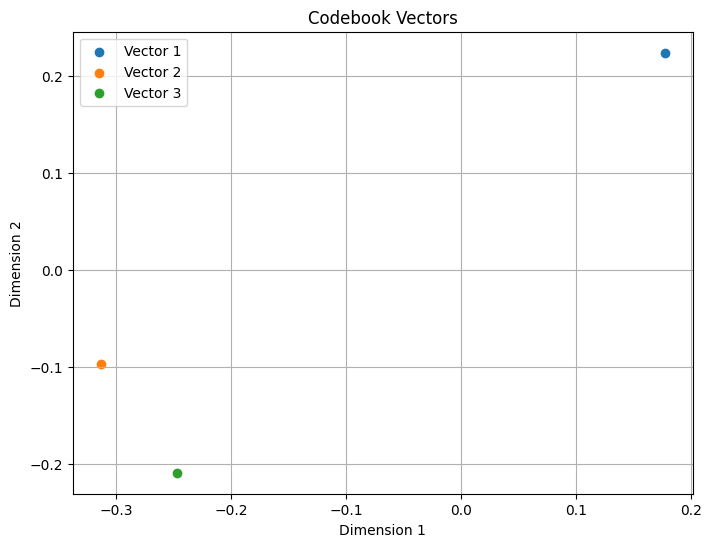

In [16]:
import matplotlib.pyplot as plt

# Function to plot 2D vectors from the codebook
def plot_codebook_vectors(vq_module):
    # Get the codebook vectors
    codebook = vq_module.embedding.weight.data.cpu().numpy()

    # Plot each 2D vector from the codebook
    plt.figure(figsize=(8, 6))
    for i in range(len(codebook)):
        plt.scatter(codebook[i][0], codebook[i][1], label=f'Vector {i+1}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Codebook Vectors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot codebook vectors after checking VectorQuantization output
def check_and_plot_codebook():
    # Assuming 3 channels for the input tensor (modify as needed)
    in_channels = 3
    sample_input = torch.randn(1, in_channels, 64, 64)  # Creating a sample input tensor

    # Initialize the VectorQuantization module
    vq = VectorQuantization(number_embeddings=3, embedding_dimension=2)

    # Pass the sample input through the VectorQuantization module
    quantized_output, vq_loss = vq(sample_input)

    # Print the output shape and loss
    print(f"Quantized output shape: {quantized_output.shape}")
    print(f"VQ Loss: {vq_loss}")

    # Plot codebook vectors
    plot_codebook_vectors(vq)

# Call the function to check the output and plot codebook vectors
check_and_plot_codebook()


In [18]:
class Decoder(nn.Module):
    def __init__(self, out_channels=128, residual_layers=2, hidden_layers=32):
        super(Decoder, self).__init__()

        self.inverse_residual_block = ResidualBlocks(out_channels,out_channels,residual_layers,hidden_layers)

        self.trans_layer1 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels,out_channels//2,4,2,1),
                                    nn.ReLU()
        )
        self.trans_layer2 = nn.Sequential(
                                    nn.ConvTranspose2d(out_channels//2,3,4,2,1),
        )

    def forward(self, x):
        x = self.inverse_residual_block(x)
        x = self.trans_layer1(x)
        x = self.trans_layer2(x)
        return x

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Define a simple input tensor for testing
def generate_sample_input(batch_size, out_channels, height, width):
    return torch.randn(batch_size, out_channels, height, width)

# Define a check function for the Decoder class
def check_decoder():
    # Assuming dimensions for the test input
    batch_size = 1
    out_channels = 128
    height = 32
    width = 32

    # Creating a sample input tensor
    sample_input = generate_sample_input(batch_size, out_channels, height, width)

    # Initialize the Decoder module
    decoder = Decoder(out_channels=out_channels, residual_layers=2, hidden_layers=32)

    # Pass the sample input through the Decoder module
    output = decoder(sample_input)

    # Print the output shape
    print(f"Decoder Output Shape: {output.shape}")

# Call the function to check the Decoder class
check_decoder()


Decoder Output Shape: torch.Size([1, 3, 128, 128])


## Define and train the network

In [20]:

class VQVAENet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, in_channels=1):
        super(VQVAENet, self).__init__()
        self.encoder = Encoder(in_channels)
        self.hidden1 = nn.Conv2d(128, embedding_dim, 1, 1)
        self.vq = VectorQuantization(num_embeddings, embedding_dim)
        self.hidden2 = nn.Conv2d(embedding_dim, 128, 3, 1, 1)
        self.decoder = Decoder()  # Use the modified Decoder

    def forward(self, x):
        x = self.encoder(x) #outputs an image of size (batch x 128 x original_width x original_height)

        x = self.hidden1(x) #outputs an image of size (batch x 64 x width x height)

        quantized_vector,vq_loss= self.vq(x) #No change in size of image

        x = self.hidden2(quantized_vector) #outputs an image of size (batch x 128 x width x height)

        x = self.decoder(x) #outputs image with dimensions of original image

        return x,vq_loss

In [21]:
model = VQVAENet(3,2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [22]:
#Hyperparameters
batch_size = 400
train_iterations = 400

In [23]:

from tqdm.notebook import tqdm
# Define a function to train the model
def train(data_loader):
    recon_losses = []
    vq_losses = []
    total_losses = []
    codebook_vectors = []

    model.train()
    for data, _ in tqdm(training_loader, desc="Training", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output, vq_loss = model(data)
        recon_loss = F.mse_loss(output, data)
        loss = recon_loss + vq_loss
        loss.backward()
        optimizer.step()

        recon_losses.append(recon_loss.item())
        vq_losses.append(vq_loss.item())
        total_losses.append(loss.item())
        codebook_vectors.append(model.vq.embedding.weight.clone().detach().cpu().numpy())

    return recon_losses, vq_losses, total_losses, codebook_vectors

Recon_loss, VQ_loss, Total_loss, Codebook_vectors = train(training_loader)

Training:   0%|          | 0/938 [00:00<?, ?batch/s]

<ipython-input-23-320fa898157c>:14: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)
<ipython-input-23-320fa898157c>:14: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(output, data)


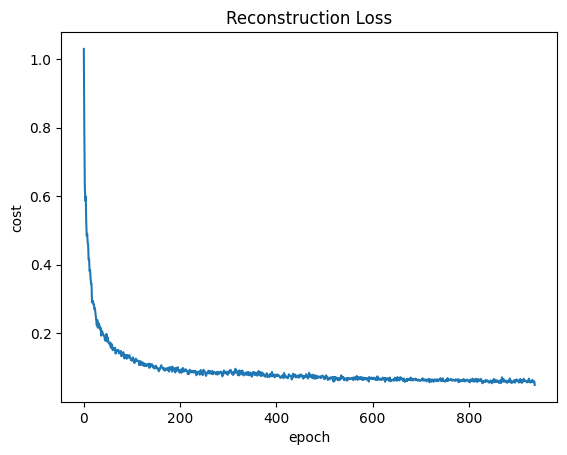

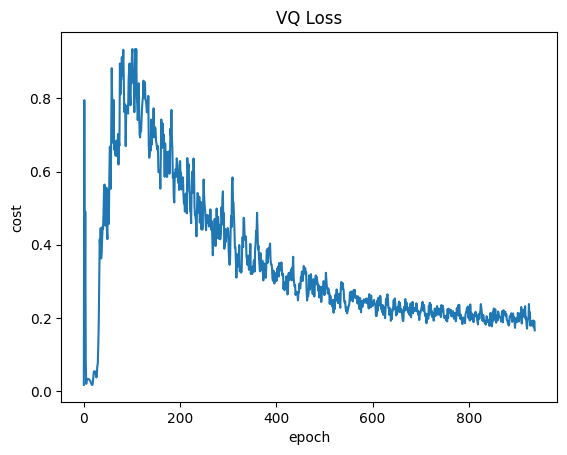

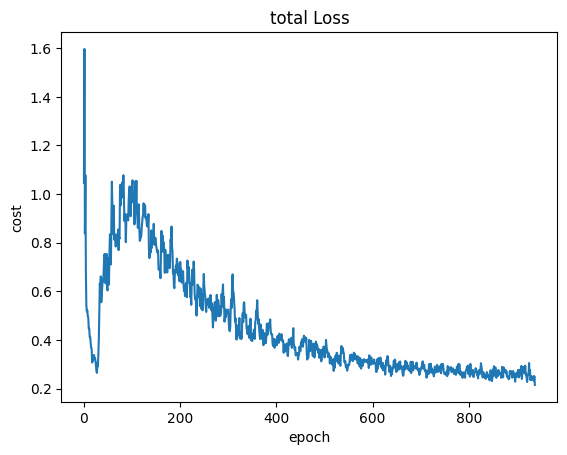

In [56]:

#plotting Recon Loss
plt.plot(Recon_loss)
plt.title("Reconstruction Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

#plotting vq-loss
plt.plot(VQ_loss)
plt.title("VQ Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

#plotting vq-loss
plt.plot(Total_loss)
plt.title("total Loss")
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()


In [57]:
import plotly.graph_objs as go

# Assuming Codebook_vectors contains a list of NumPy arrays representing codebook vectors at different iterations
traces = []
for i, codebook_vector in enumerate(Codebook_vectors):

    trace = go.Scatter(
        x=codebook_vector[0, :],  # X-coordinates for the codebook vector over iterations
        y=codebook_vector[1, :],  # Y-coordinates for the codebook vector over iterations
        mode='markers+lines',
        name=f'Codebook Vector {i+1}'
    )
    traces.append(trace)

# Create layout for the plot
layout = go.Layout(
    title='Movement of Codebook Vectors',
    xaxis=dict(title='X-coordinate'),
    yaxis=dict(title='Y-coordinate'),
    hovermode='closest'
)

# Create the figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.show()


In [58]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Extract X and Y coordinates for each codebook vector across iterations
num_iterations = len(Codebook_vectors)
print(num_iterations)
codebook_1 = np.zeros((num_iterations, 2))
codebook_2 = np.zeros((num_iterations, 2))
codebook_3 = np.zeros((num_iterations, 2))

for i, codebook_vector in enumerate(Codebook_vectors):
    codebook_1[i] = codebook_vector[0,:]
    codebook_2[i] = codebook_vector[1,:]
    codebook_3[i] = codebook_vector[2,:]



938


In [59]:
import torch
import matplotlib
matplotlib.use('Agg')  # Use the 'Agg' backend for GPU acceleration
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming you have the data in codebook_1, codebook_2, and codebook_3 arrays

num_iterations = min(len(codebook_1), len(codebook_2), len(codebook_3))

# For GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in tqdm(range(num_iterations)):
    plt.figure(figsize=(15, 10))  # Set figure size if needed

    # Plot codebook vectors with fixed axis limits and annotations
    plt.plot(codebook_1[:i + 1, 0], codebook_1[:i + 1, 1], 'o-', label='Codebook Vector 1')
    plt.plot(codebook_2[:i + 1, 0], codebook_2[:i + 1, 1], 'o-', label='Codebook Vector 2')
    plt.plot(codebook_3[:i + 1, 0], codebook_3[:i + 1, 1], 'o-', label='Codebook Vector 3')

    # Set fixed axis limits
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    # Annotate the number of iterations
    plt.text(0.5, 0.5, f'Iteration: {i}', ha='center', va='center', transform=plt.gca().transAxes)

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'iteration_{i}.png')  # Save each frame as an image
    plt.close()  # Close the figure to free memory


100%|██████████| 938/938 [05:04<00:00,  3.08it/s]


In [1]:
%%capture
!pip install imageio

In [2]:
import imageio
from IPython.display import Image, display

# Define the file names and sort them in the correct order
file_names = [f'iteration_{i}.png' for i in range(num_iterations)]

# Create GIF from the saved images
images = [imageio.imread(filename) for filename in file_names]
output_file = 'codebook_vectors.gif'
imageio.mimsave(output_file, images, duration=1)  # Adjust duration as needed

# Display the generated GIF in the notebook
display(Image(filename=output_file))

NameError: name 'num_iterations' is not defined

In [ ]:
# Display the generated GIF in the notebook
display(Image(filename=output_file))

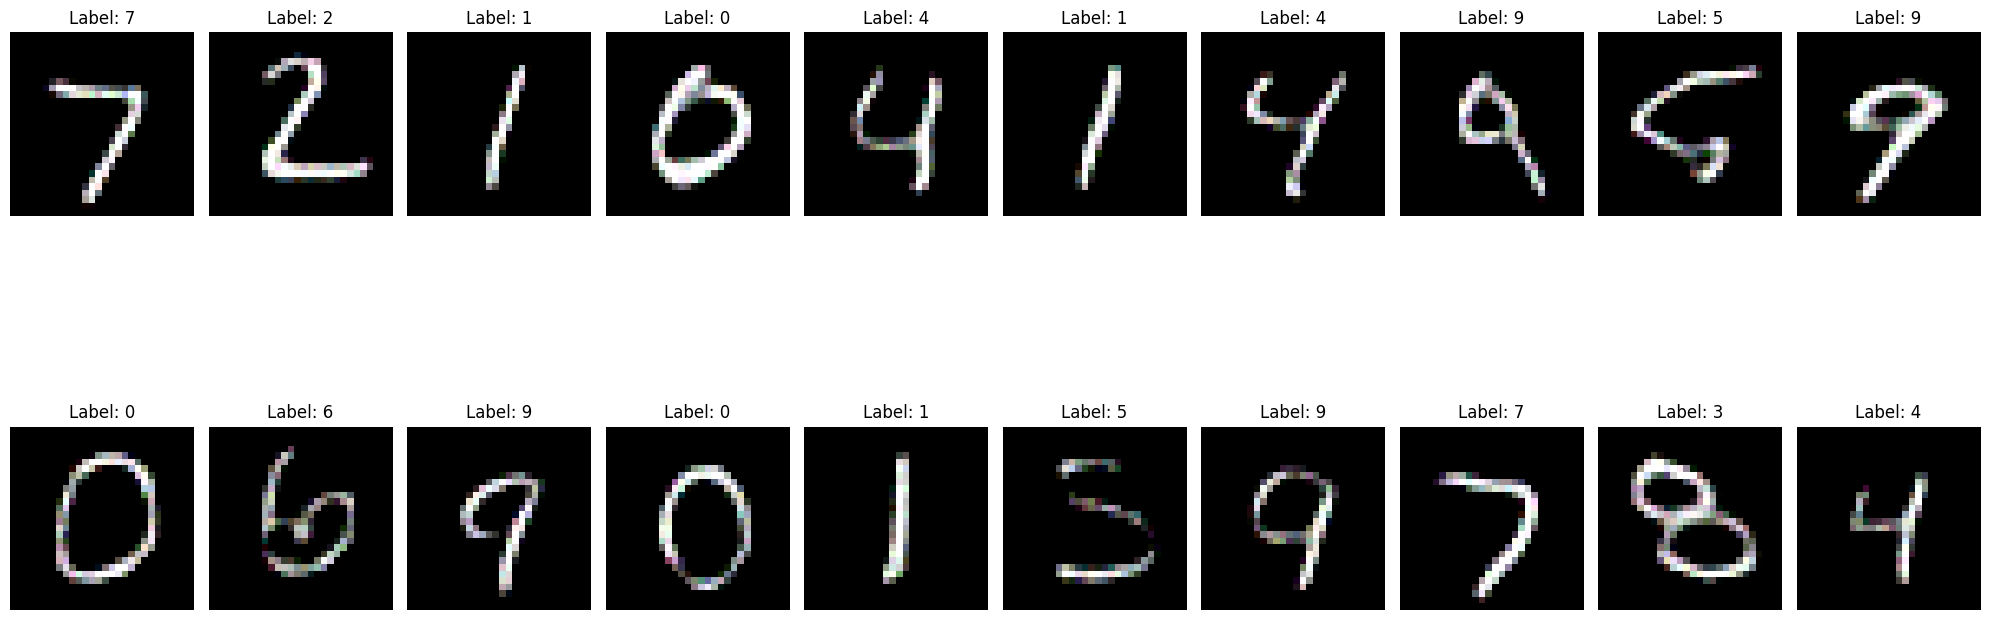

In [55]:
# Set your model to evaluation mode
model.eval()

# Plot some images from the dataset with generated samples
def plot_images_gen(dataset, num_images=20):
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 10))  # Adjust figsize for better visualization
    for i in range(num_images):
        image, label = dataset[i]
        input_image = image.unsqueeze(0).to(device)  # Add a batch dimension and move to device
        with torch.no_grad():
            output_image = model(input_image)[0].cpu().detach().numpy()  # Generate output image
        # Convert the output image to grayscale
        output_image = np.mean(output_image, axis=0)  # Take the mean along the channel axis to convert to grayscale
        # Ensure the output image shape is (28, 28)
        output_image = output_image.squeeze() if output_image.shape[0] == 1 else np.moveaxis(output_image, 0, -1)
        axes[i // (num_images // 2), i % (num_images // 2)].imshow(output_image, cmap='gray')
        axes[i // (num_images // 2), i % (num_images // 2)].set_title(f"Label: {label}")
        axes[i // (num_images // 2), i % (num_images // 2)].axis('off')
    plt.tight_layout()
    plt.show()

plot_images_gen(test_set, num_images=20)


**Refrence:**
https://arxiv.org/pdf/1711.00937.pdf